Grayscale Image (Height, Width #Channel=1): represented by a 2x2 matrix. Pixel p in [0, 255]

Color Image (Height, Width, Channel=3): represented by three 2x2 matrixes: red, green, blue. Pixel [r g b].T, each in [0, 255]


In [8]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math


img_path = '/content/cat.jpg'
img = cv2.imread(img_path , 0) # 0 for grayscale, 1 for color image
# print(img)

In [9]:
def show_img(image):
  cv2_imshow(image)
  cv2.waitKey()
  cv2.destroyAllWindows()

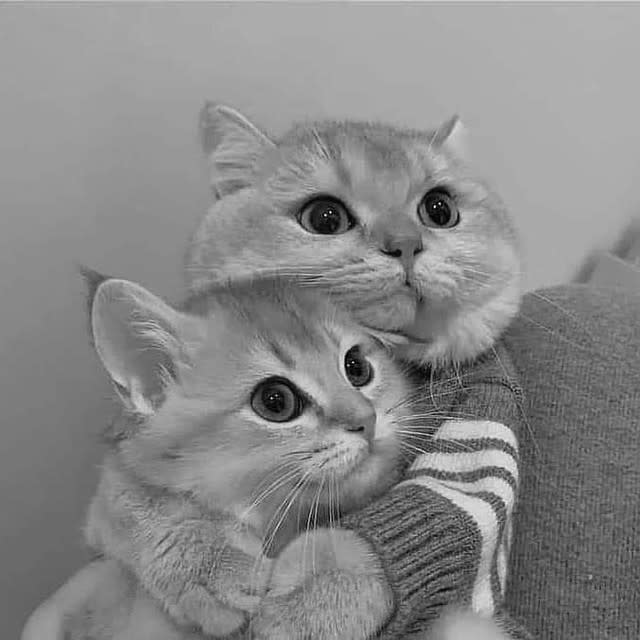

In [10]:
show_img(img)

# Mục mới

Image Resize

#####Missing Data


*   Nearest-neighbor interpolation (up to flooring or ceilling)
     
     Ex: A 3x3 Image to Upsampling to a 6x6 Image (if there is a ceil having equal distance to both sides, then its value based on whether flooring or ceilling its index, but it may miss information, if zoom up, it may cause blur) -> using linear Interpolation
*   Linear Interpolation
    + Simple interpolation:
         
                y ~ (x2-x)/(x2-x1)*y1 + (x-x1)/(x2-x1)*y2
    + Bilinear Interpolation: Bilinear interpolation considers the closest 2x2 neighborhood of known pixel values surrounding the unknown pixel. It then takes a weighted average of these 4 pixels to arrive at its final interpolated value. This results in much smoother looking images than nearest neighbor.

    + Bicubic Interpolation: icubic goes one step beyond bilinear by considering the closest 4x4 neighborhood of known pixels — for a total of 16 pixels. Since these are at various distances from the unknown pixel, closer pixels are given a higher weighting in the calculation. Bicubic produces noticeably sharper images than the previous two methods, and is perhaps the ideal combination of processing time and output quality. For this reason it is a standard in many image editing programs (including Adobe Photoshop), printer drivers and in-camera interpolation.
    * Notice that: some last value of the column n-th and row n-th can be found by nearest-neighbor or linear interpolation

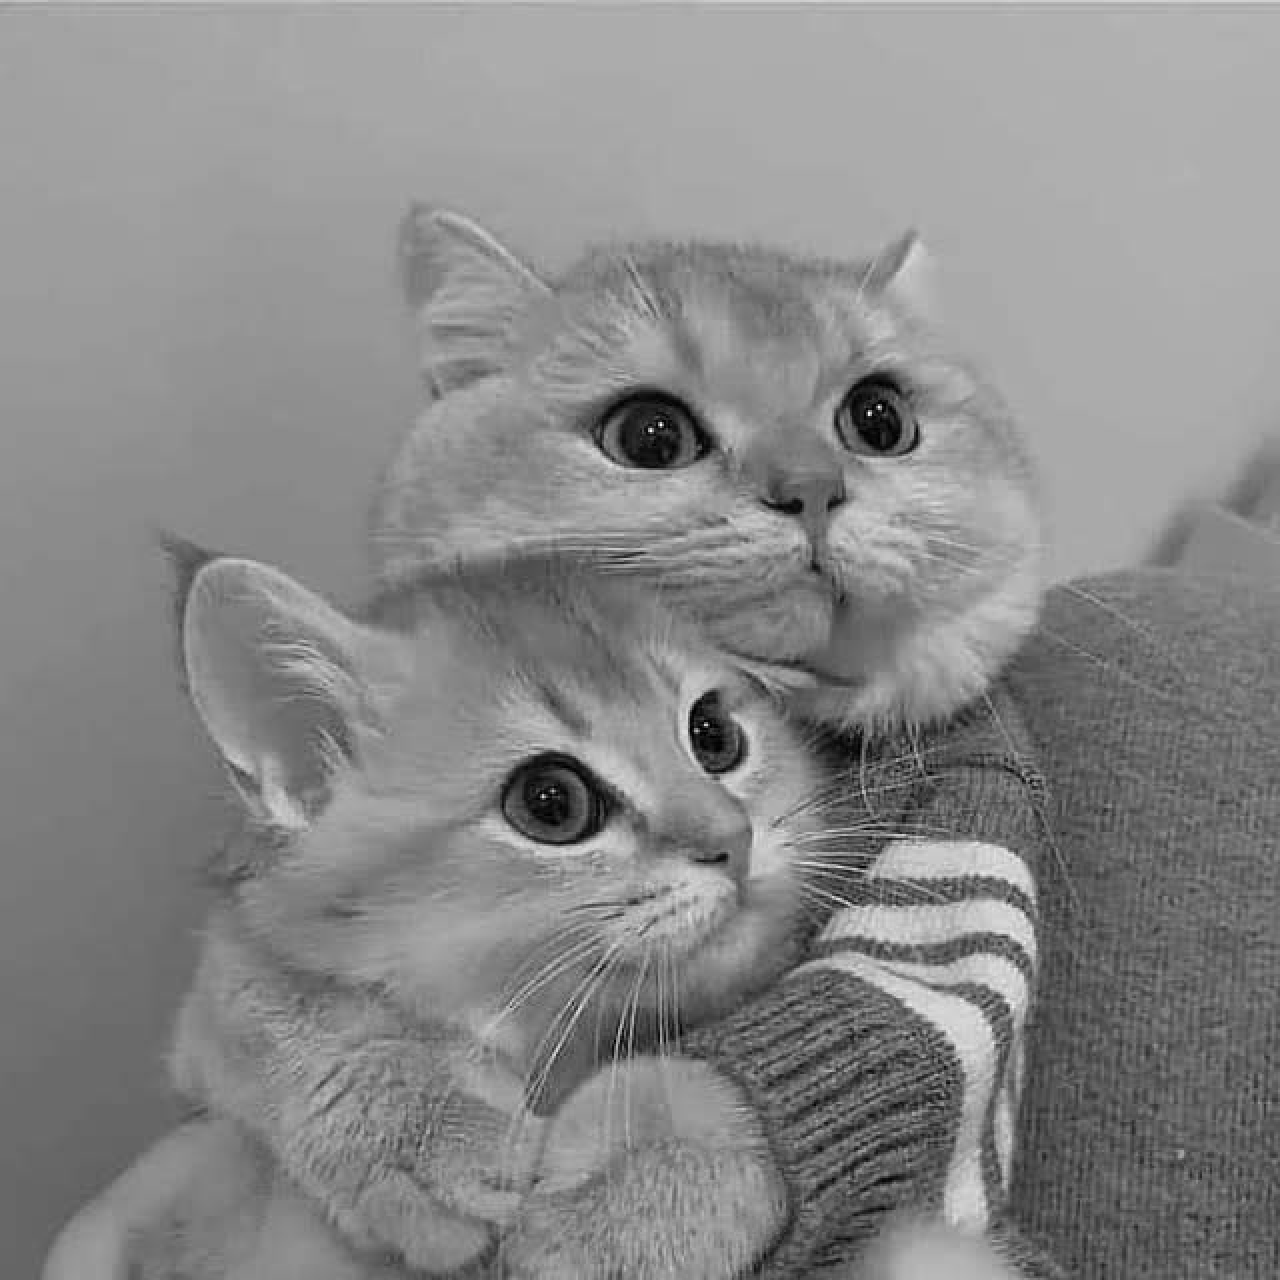

In [11]:
# Eg: Nearest-neighbor interpolation
def nearest_neighbor_interpulation(old_img, new_height, new_width):
  height, width = old_img.shape
  new_img = np.zeros((new_height, new_width))
  scale = [int(new_height/height), int(new_width/width)]
  for i in range(new_height):
    for j in range(new_width):
      new_img[i][j] = old_img[i//scale[0]][j//scale[1]]
  return new_img

new_img = nearest_neighbor_interpulation(img, img.shape[0]*2, img.shape[1]*2)

show_img(new_img)

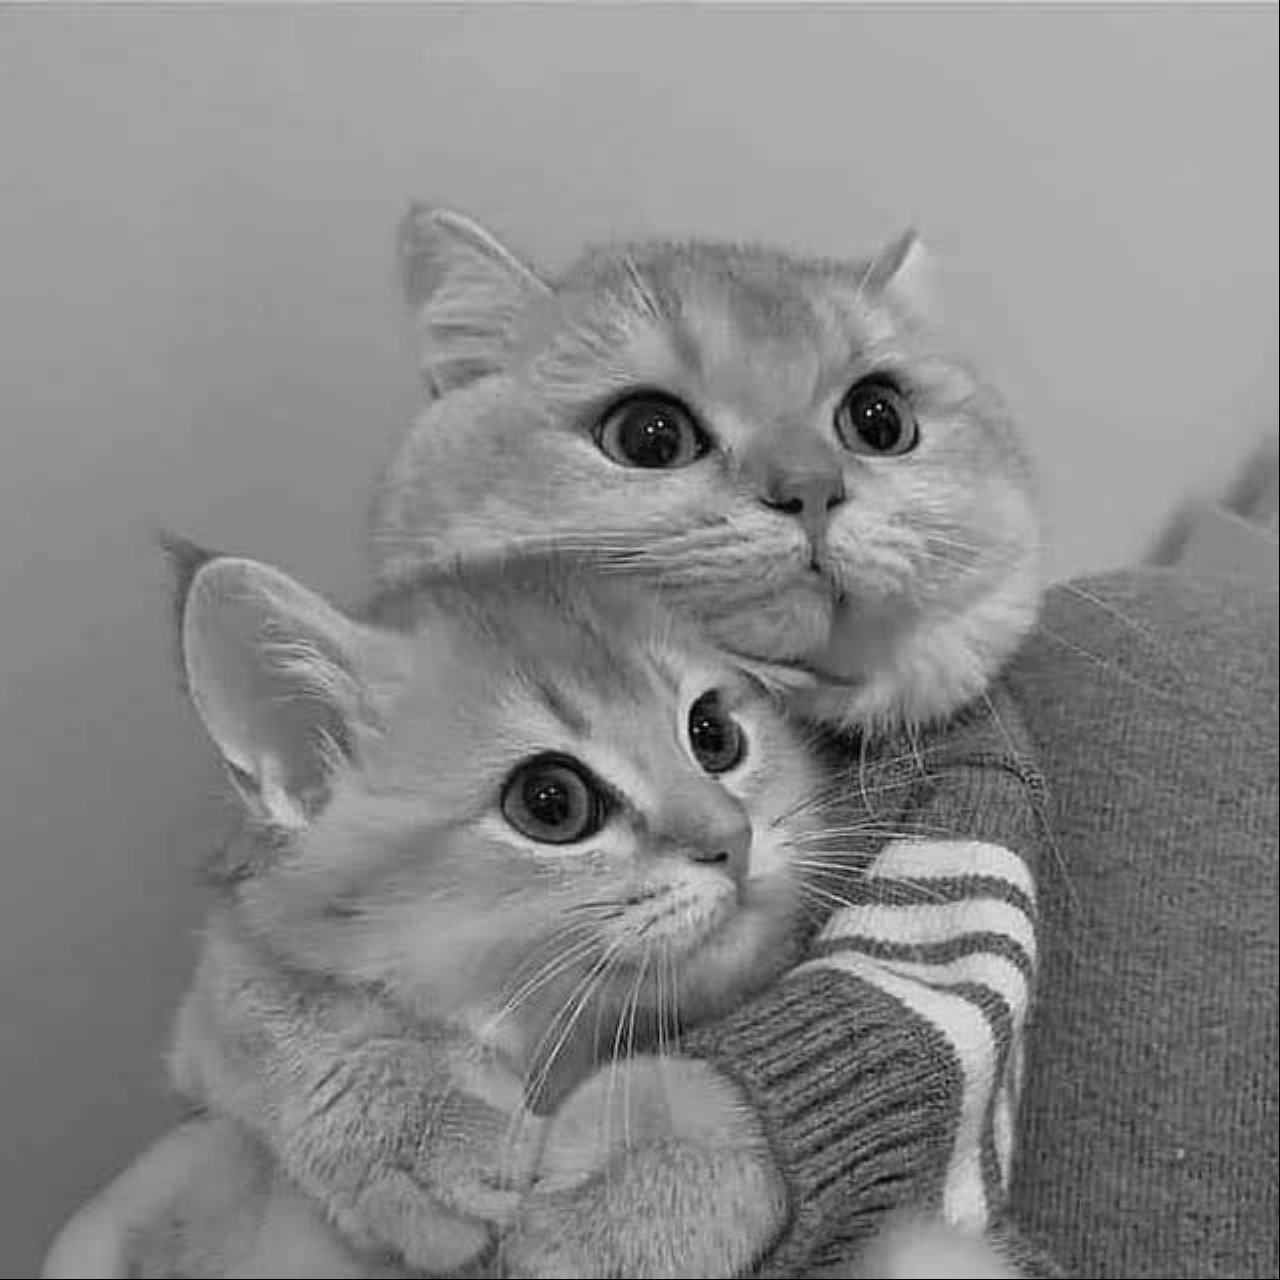

In [12]:
# Eg Linear Interpolation
def bilinear_interpolation(old_img, new_height, new_width):
  height, width = old_img.shape
  new_img = np.full((new_height, new_width), -1)
  scale = [int(new_height/height), int(new_width/width)]
  for i in range(new_height):
    for j in range(new_width):
      if i%scale[0] == 0 and j%scale[1] == 0:
        new_img[i][j] = old_img[i//scale[0]][j//scale[1]]

  for i in range(new_height):
    for j in range(new_width):
      if i == new_height-1 or j == new_width-1:
        new_img[i][j] = 0
      elif i%scale[0] == 0 and new_img[i][j] == -1:
        x1 = j//scale[1]*scale[1]
        x2 = x1 + scale[1]
        y1 = new_img[i][x1]
        y2 = new_img[i][x2]
        new_img[i][j] = (x2-j)/(x2-x1)*y1 + (j-x1)/(x2-x1)*y2

  for i in range(new_height):
    for j in range(new_width):
      if new_img[i][j] == -1:
        x1 = i//scale[0]*scale[0]
        x2 = x1 + scale[0]
        y1 = new_img[x1][j]
        y2 = new_img[x2][j]
        new_img[i][j] = (x2-i)/(x2-x1)*y1 + (i-x1)/(x2-x1)*y2
  return new_img

new_img = bilinear_interpolation(img, img.shape[0]*2, img.shape[1]*2)

show_img(new_img)

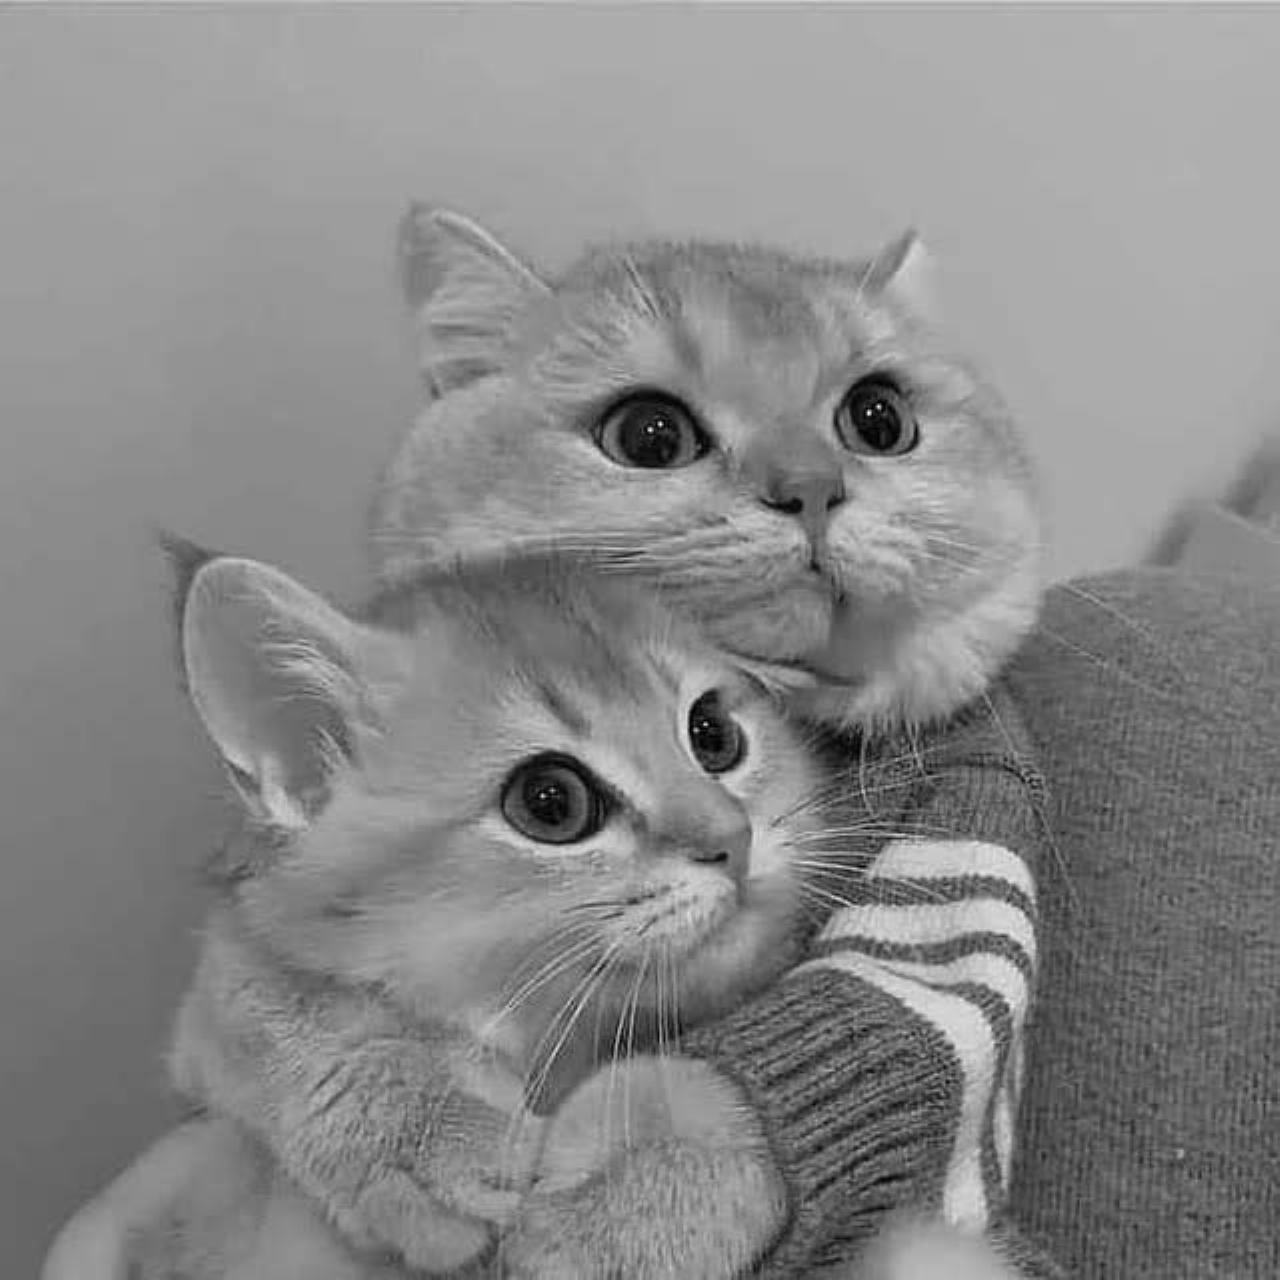

In [14]:
def bl_resize_special(original_img, old_h, old_w, new_h, new_w):
	resized = np.zeros((new_h, new_w))
	#Calculate horizontal and vertical scaling factor
	w_scale_factor = (old_w ) / (new_w ) if new_h != 0 else 0
	h_scale_factor = (old_h ) / (new_h ) if new_w != 0 else 0
	for i in range(new_h):
		for j in range(new_w):
			#map the coordinates back to the original image
			x = i * h_scale_factor
			y = j * w_scale_factor
			#calculate the coordinate values for 4 surrounding pixels.
			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x)][int(y)]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x)][int(y_floor)]
				q2 = original_img[int(x)][int(y_ceil)]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor)][int(y)]
				q2 = original_img[int(x_ceil)][int(y)]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor][y_floor]
				v2 = original_img[x_ceil][y_floor]
				v3 = original_img[x_floor][y_ceil]
				v4 = original_img[x_ceil] [y_ceil]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i, j] = q
	return resized.astype(np.uint8)


new_img = bl_resize_special(img, img.shape[0], img.shape[1], img.shape[0]*2, img.shape[1]*2)

show_img(new_img)

Color picture

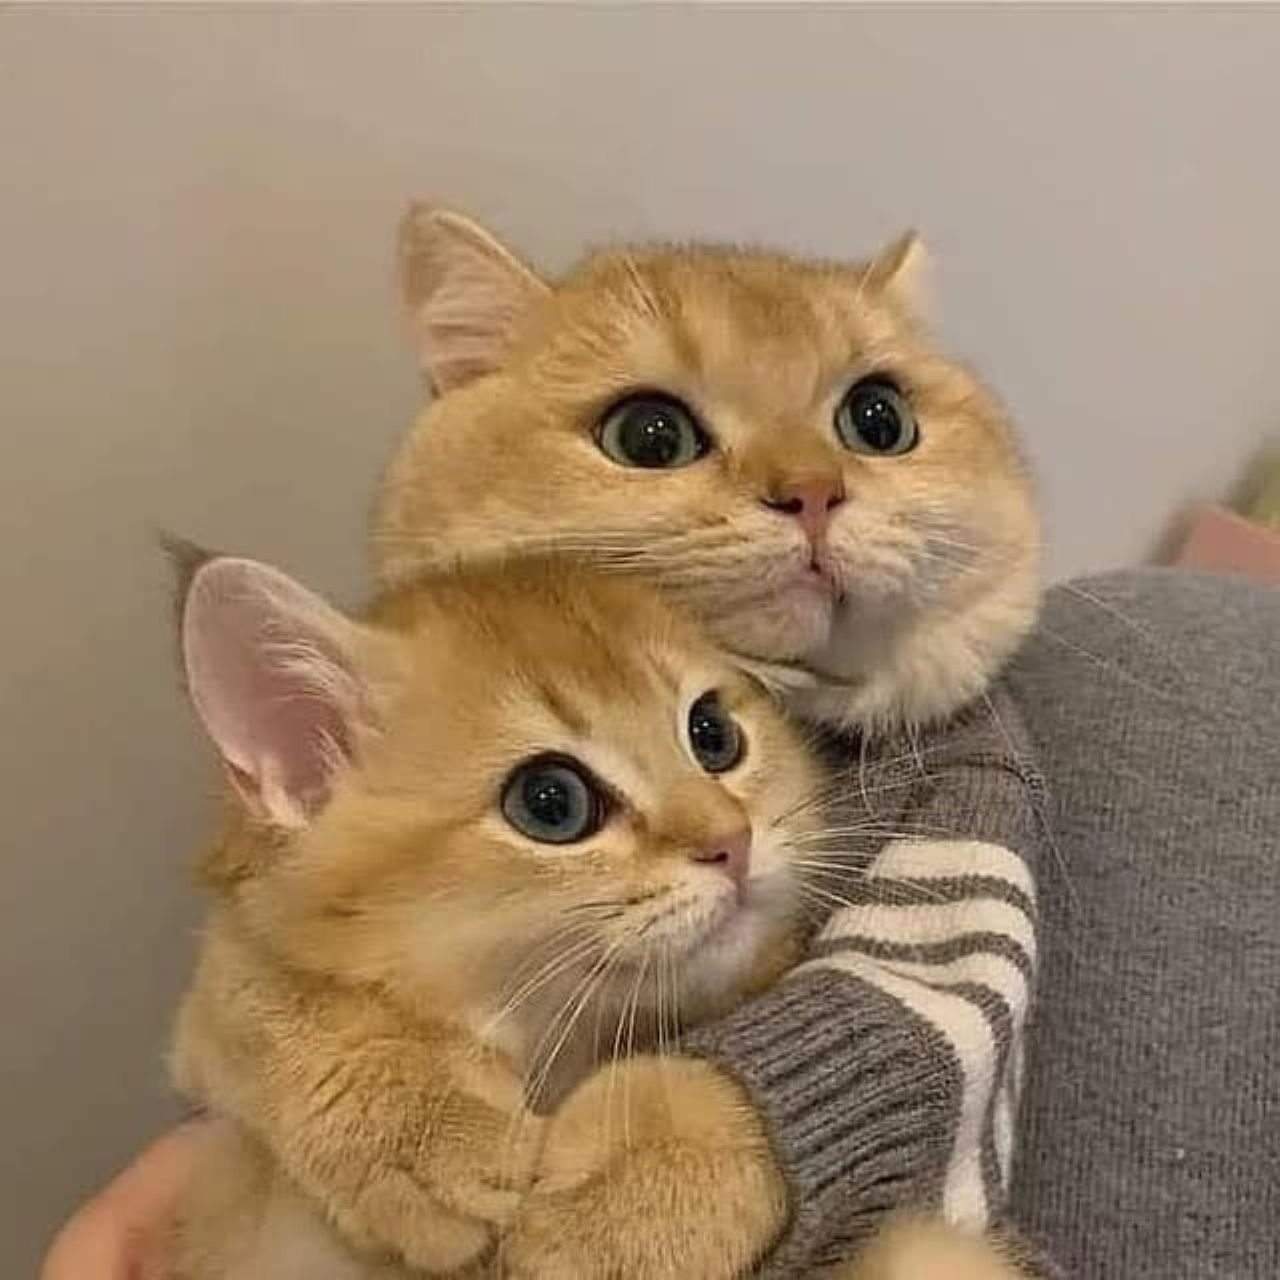

In [16]:
def bl_resize_color(original_img, new_h, new_w):
	#get dimensions of original image
	old_h, old_w, c = original_img.shape
	#create an array of the desired shape.
	#We will fill-in the values later.
	resized = np.zeros((new_h, new_w, c))
	#Calculate horizontal and vertical scaling factor
	w_scale_factor = (old_w ) / (new_w ) if new_h != 0 else 0
	h_scale_factor = (old_h ) / (new_h ) if new_w != 0 else 0
	for i in range(new_h):
		for j in range(new_w):
			#map the coordinates back to the original image
			x = i * h_scale_factor
			y = j * w_scale_factor
			#calculate the coordinate values for 4 surrounding pixels.
			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x), int(y), :]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x), int(y_floor), :]
				q2 = original_img[int(x), int(y_ceil), :]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor), int(y), :]
				q2 = original_img[int(x_ceil), int(y), :]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor, y_floor, :]
				v2 = original_img[x_ceil, y_floor, :]
				v3 = original_img[x_floor, y_ceil, :]
				v4 = original_img[x_ceil, y_ceil, :]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i,j,:] = q
	return resized.astype(np.uint8)


image = cv2.imread(img_path , 1)
new_image = bl_resize_color(image, img.shape[0]*2, img.shape[1]*2)

show_img(new_image)